In [18]:
! eups list -s lsst_distrib

   gdf42428520+bd672e3dc1 	current w_2023_16 setup


In [29]:
import pylab as plt
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
from lsst.ip.isr.isrTask import IsrTask
from lsst.cp.pipe.cpCombine import CalibCombineTask
import traceback

In [76]:
def display(exposure,title=None):
    afwDisplay.setDefaultBackend('matplotlib') 

    fig = plt.figure(figsize=(10,10))
    afw_display = afwDisplay.Display(1)
#    afw_display.scale('asinh', 'zscale')
    afw_display.scale('linear', 'zscale')
    afw_display.setMaskTransparency(90)
    afw_display.mtv(exposure.getImage())
    detector = exposure.getDetector()
    try:
        cameraGeom.utils.overlayCcdBoxes(detector, isTrimmed=True, display=afw_display, nQuarter=2)
    except:
        pass
    mds=[]
    try:
        md = exposure.getMetadata()
    except:
#        pass
        traceback.print_exc()
    
    for a in [ "FILENAME", "FILTER", "FILTER2", "CPP_INPUT_EXPT_0", "LSST ISR FINAL MEDIAN C10" ]:
        try:
            mds.append(f"{md[a]}")
        except:
            pass
#            traceback.print_exc()
    mds=" ".join(mds)
    plt.title(f"{title}: {mds}")
    plt.gca().axis('off')

In [77]:
#repo_path = "/sdf/data/rubin/repo/main"
repo_path = "/repo/embargo"
butler = Butler(repo_path)
collections = 'LSSTComCam/raw/all,LSSTComCam/calib'.split(",")
butler = Butler(repo_path,collections=collections)
registry = butler.registry

In [94]:
kwargs={
"datasetType": "raw",
"collections": collections,
"where":
"""
instrument='LSSTComCam'
and detector=4
and exposure.day_obs=20230510
"""
}

datasetRefs = list(registry.queryDatasets(**kwargs))
print( f"You have {len(datasetRefs)} in this repository with the condition supplied {kwargs}")

You have 5751 in this repository with the condition supplied {'datasetType': 'raw', 'collections': ['LSSTComCam/raw/all', 'LSSTComCam/calib'], 'where': "\ninstrument='LSSTComCam'\nand detector=4\nand exposure.day_obs=20230510\n"}


In [106]:
kwargs={
"datasetType": "raw",
"collections": collections,
"where":
f"""
instrument='LSSTComCam'
and exposure.id={datasetRefs[-1].dataId["exposure"]}
"""
}

datasetRefs = list(registry.queryDatasets(**kwargs))
print( f"You have {len(datasetRefs)} in this repository with the condition supplied {kwargs}")

You have 9 in this repository with the condition supplied {'datasetType': 'raw', 'collections': ['LSSTComCam/raw/all', 'LSSTComCam/calib'], 'where': "\ninstrument='LSSTComCam'\nand exposure.id=2023051005751\n"}


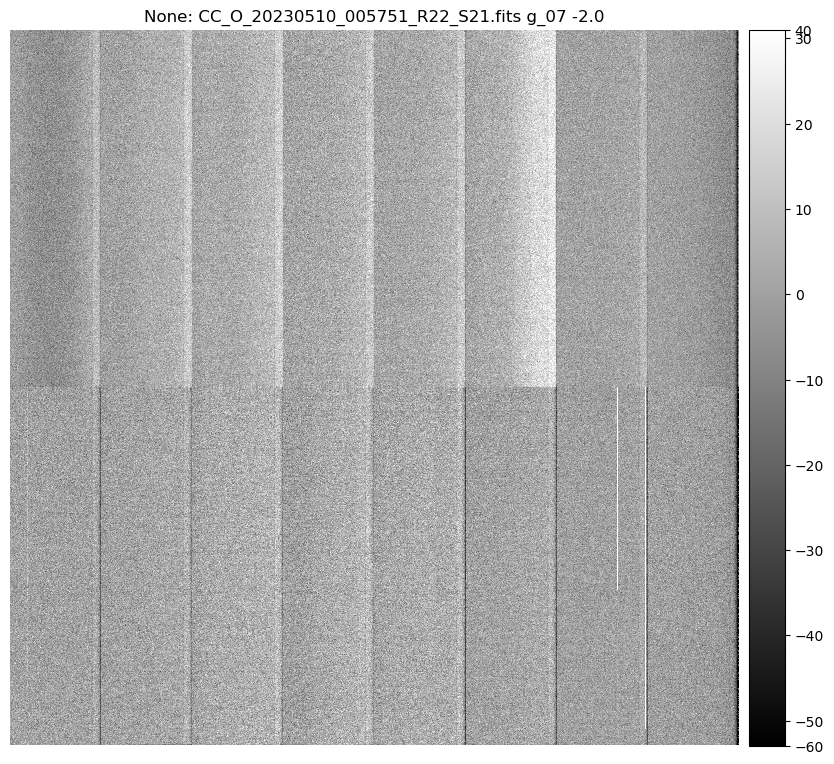

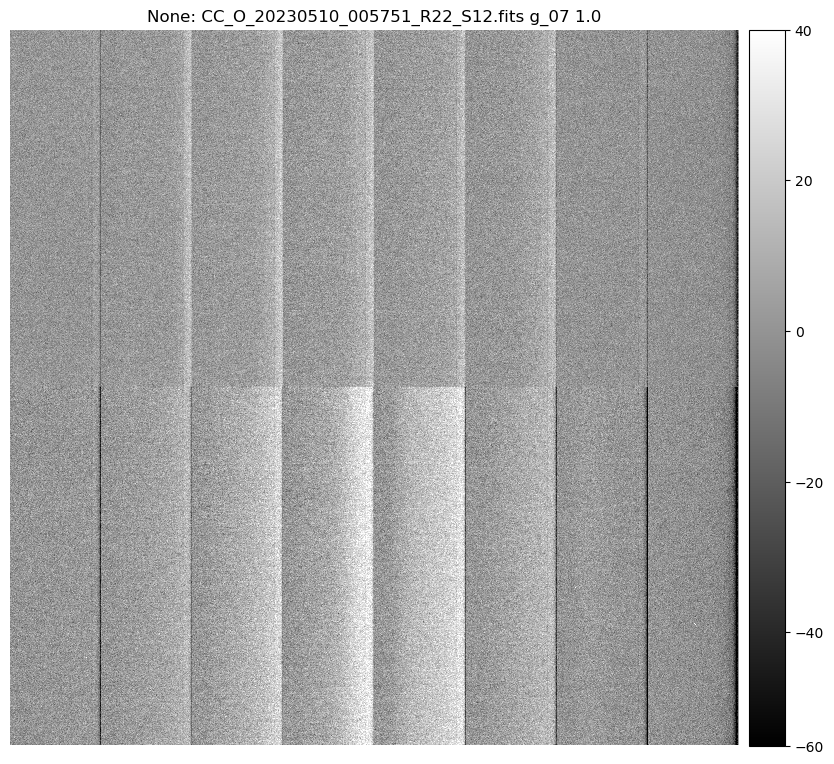

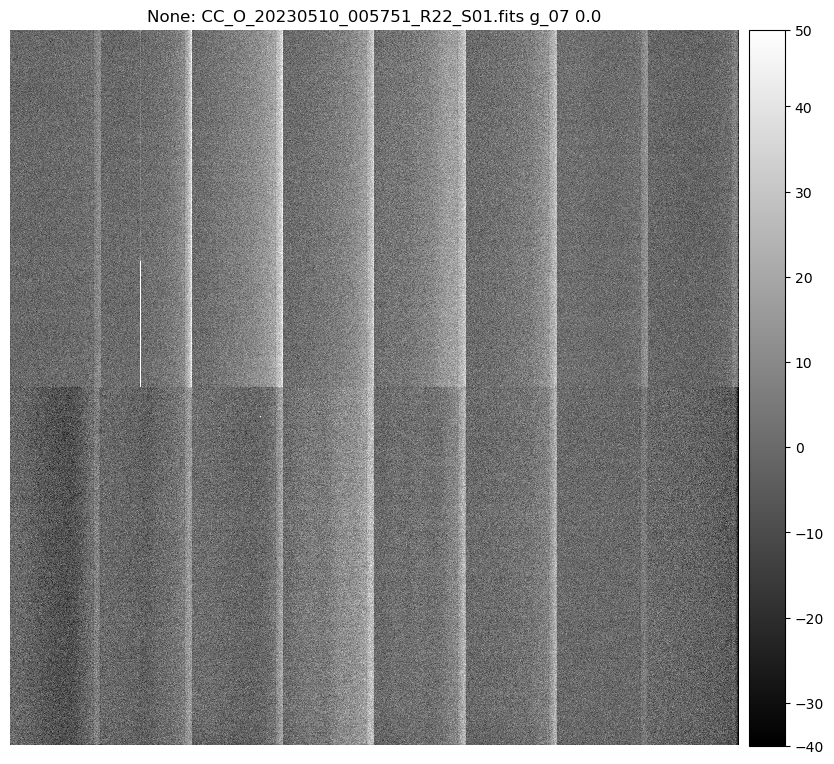

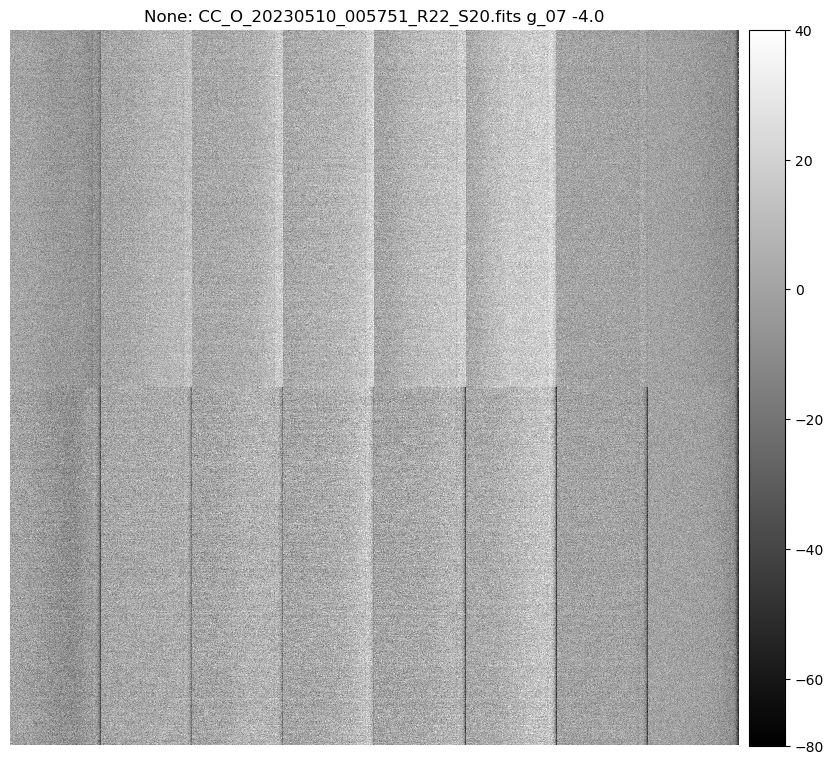

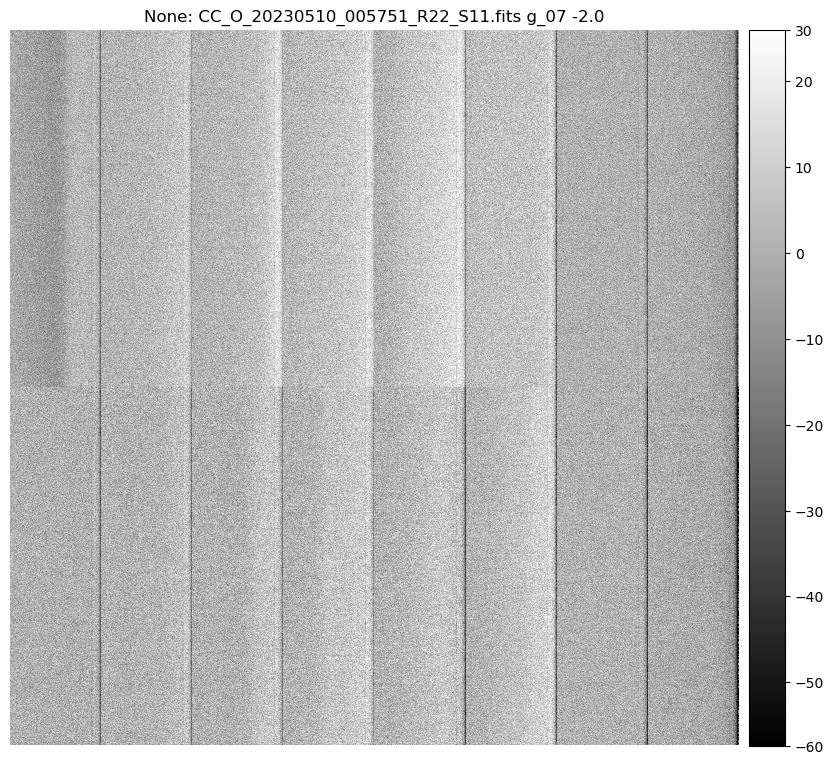

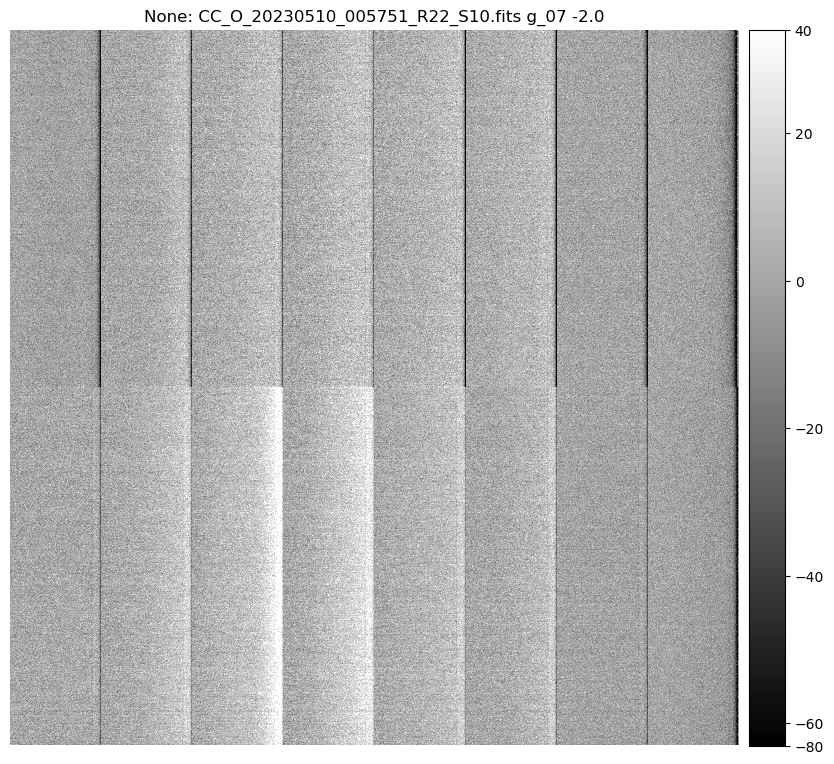

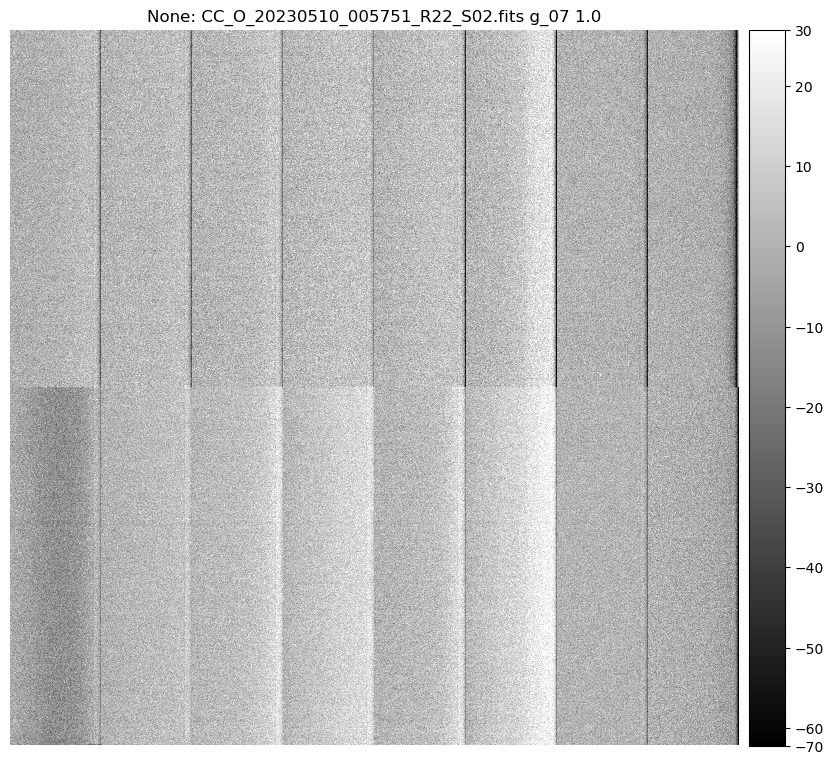

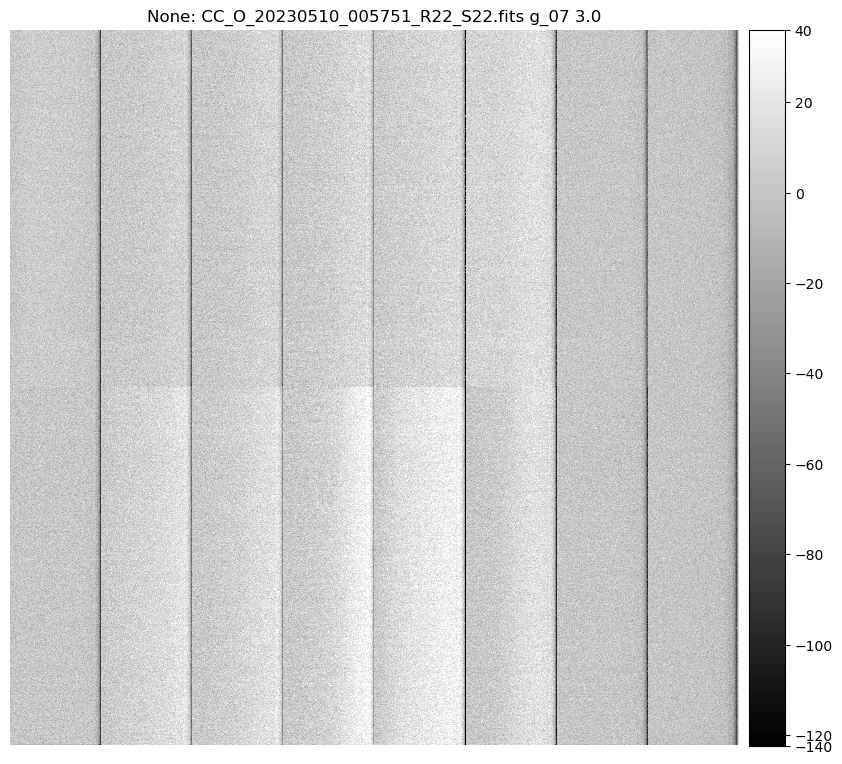

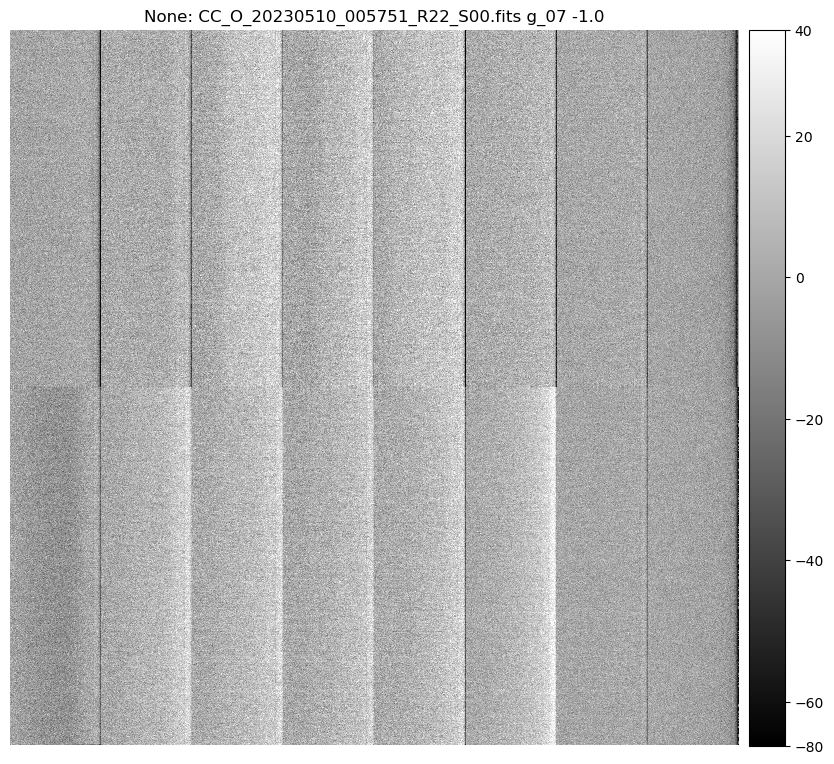

In [110]:
for aref in datasetRefs:
    img=butler.get(aref)
    isr = IsrTask()
    isr.config.doLinearize=False
    isr.config.doDark=False
    isr.config.doBias=False
    isr.config.doFlat=False
    isr.config.doDefect=False
    #isr.config.overscan.fitType: 'MEDIAN_PER_ROW'
    isr.config.overscan.fitType: 'MEAN'
    postISRCCD = isr.run(img)
    display(postISRCCD.exposure)

    plt.show()